# Parameter Tuning
    Find best predictive window from 2 years to 2 months

In [1]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.svm import SVR

# empty list to append metric values
mae_gen = []
rmse_gen = []
mae_nor = []
mae_spi = []
rmse_nor = []
rmse_spi = []

dates = [2017010000,
         2017030000, 
         2017050000, 
         2017070000,
         2017090000, 
         2017110000,
         2018010000, 
         2018030000, 
         2018050000,
         2018070000,
         2018090000,
         2018110000]

dates_labels = ['24 ', 
                '22 ',
                '20 ',  
                '18 ', 
                '16 ', 
                '14 ', 
                '12 ',
                '10 ',
                '8 ',
                '6 ',
                '4 ',
                '2 ']

# Data set processing and tuning:

In [2]:
for i in dates:
    # data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)
    data = data.loc[data.index > i, :]
    
    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(X.median(), inplace = True)
    y.fillna(y.median(), inplace = True)
    
    X = X.astype('float64')
    X = X.round(20)
    
    # divide data into train and test 
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.075, shuffle=False)
    
    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    # create regressor 
    regressor = SVR(kernel='linear')
    regressor.fit(X_train, y_train)

    # predict for X_test  
    y_pred = regressor.predict(X_test)

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)  

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(ne

# Results:

In [3]:
results = pd.DataFrame({                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = dates_labels)

results.to_csv('Results_SVM_Predictive_window.csv')

# Highlight best results:

In [4]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
24,47.284144,22.284302,111.366476,66.319082,19.467506,14.241963
22,39.276318,21.758760,88.376467,63.955497,19.117954,13.833905
20,38.907022,21.124784,87.616156,62.040107,19.020054,13.476647
18,39.978426,21.602880,91.129273,64.999824,19.485421,13.717243
16,31.226813,19.177397,72.750803,58.356030,15.182456,12.420654
14,31.772371,18.669047,75.611072,61.065258,14.447600,11.457487
12,32.044625,18.333574,80.376484,65.755622,14.273801,11.149673
10,32.204669,17.195270,82.426162,67.865607,13.107182,9.578852
8,30.576885,15.301094,78.694469,64.891884,11.821696,7.801052
6,28.328231,14.237349,70.721431,56.462858,10.834365,7.347923


In [5]:
results.min()

rmse_general    28.328231
mae_general     14.237349
rmse_spike      70.721431
mae_spike       56.462858
rmse_normal     10.834365
mae_normal       7.347923
dtype: float64

# Plot results:

In [6]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>


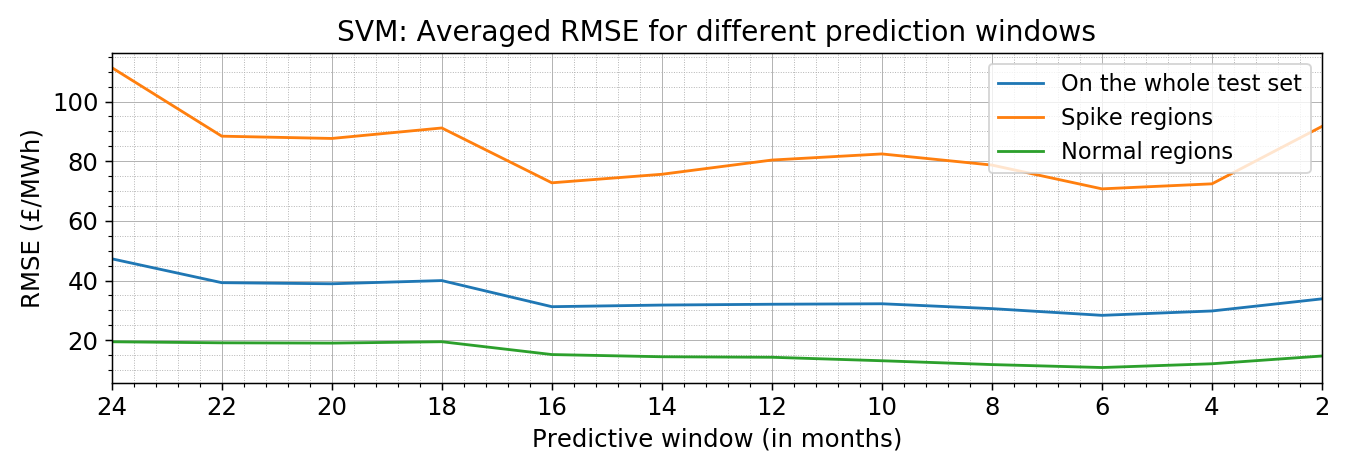

<IPython.core.display.Javascript object>


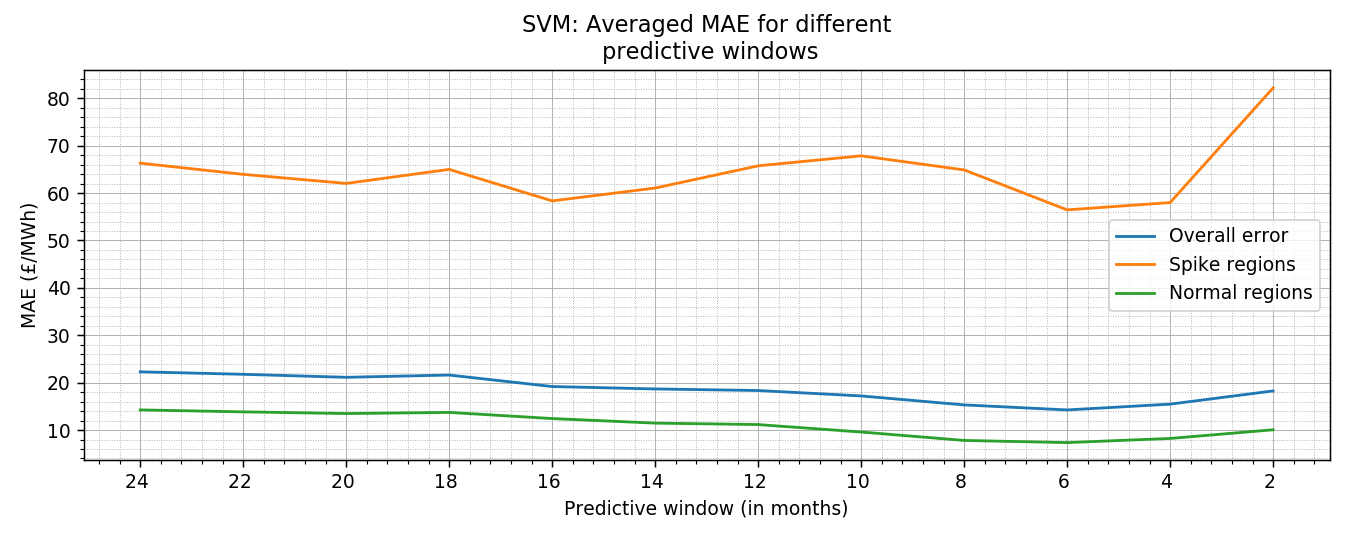

In [7]:
fontsize = 13

plt.figure(figsize=(10,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged RMSE for different prediction windows', fontsize = fontsize + 2)
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_gen, label = 'On the whole test set')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_spi, label = 'Spike regions')
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], rmse_nor, label = 'Normal regions')
plt.legend(loc = 'upper right', fontsize = fontsize - 1)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xlabel('Predictive window (in months)', fontsize = fontsize)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], list(np.arange(2, 26, 2))[::-1], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlim(0, 11)
plt.tight_layout()
plt.savefig('RMSE_predictive_window.png')

plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged MAE for different\n predictive windows')
plt.plot(mae_gen, label = 'Overall error')
plt.plot(mae_spi, label = 'Spike regions')
plt.plot(mae_nor, label = 'Normal regions')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Predictive window (in months)')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], dates_labels)
plt.tight_layout()
plt.savefig('MAE_predictive_window.png')